In [1]:
# Autoreload ensures that your python-files stay up-to-date: https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

# Move back to the root directory
%cd ..

/workspaces/seminars_as_branches


/opt/venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Model - Finetuning

In practice, most Machine Learning models are fine-tuned models. This means that:
* We base ourselves from a previously created model
* We adapt this model to work for our use-case

In Computer Vision, specifically, we tend to use a previously trained encoder, and attach our own decoder.

In [2]:
import json
from pathlib import Path
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from numpy.typing import NDArray
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from tqdm import tqdm

## Dataset

See the previous notebook (`custom_dataset.ipynb`).

In [3]:
class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]], resolution: int = 256) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        resolution : int
            Resolution to transform the images to
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())
        self.classes = sorted({x for y in self.labels for x in y})
        self.transform_resize = get_transform_resize(resolution)

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        # Load in the image as a tensor
        img = load_img(self.data_f / f"{self.keys[idx]}.png")

        # Reshape the a fixed size
        img = self.transform_resize(img[None,])[0]

        # Multi-hot encode the labels
        label = torch.FloatTensor([x in self.labels[idx] for x in self.classes])

        return {"image": img, "label": label}


def load_img(path: Path) -> torch.Tensor:
    """Load the image specified under the provided path."""
    # Read in the image
    im = Image.open(path).convert("RGB")

    # Transform to tensor
    im = to_tensor(im)

    # Make image channel first and normalized
    return im.permute(2, 0, 1) / 255.0


def to_tensor(x: torch.Tensor | NDArray[np.float32] | Image.Image) -> torch.Tensor:
    """Convert to tensor."""
    if isinstance(x, torch.Tensor):
        return x
    if isinstance(x, np.ndarray):
        return torch.Tensor(x)
    if isinstance(x, Image.Image):
        return torch.Tensor(np.array(x))
    raise Exception(f"Variable of type '{type(x)}' not supported!")


def get_transform_resize(resolution: int) -> torch.Tensor:
    """
    Transform a tensor to a fixed size.

    Parameters
    ----------
    resolution : int
        Resolution to transform to

    Returns
    -------
    torch.Tensor
        Resized image
    """
    return transforms.Compose([SquarePad(), transforms.Resize((resolution, resolution))])


class SquarePad:
    """Pad the provided image to become a square, assumes channel-first."""

    def __call__(self, x: torch.Tensor) -> torch.Tensor:
        """Pad the provided image to become a square."""
        _, _, h, w = x.shape  # batch_size, channels, width, height
        max_wh = max(w, h)
        p_left, p_right = ((max_wh - w) // 2 for _ in range(2))
        p_right += int(w % 2 == 1)
        p_bottom, p_top = ((max_wh - h) // 2 for _ in range(2))
        p_top += int(h % 2 == 1)
        padding = (p_left, p_right, p_top, p_bottom)
        return F.pad(x, padding, value=1, mode="constant")

In [4]:
# Training dataset
dataset_train = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/train.json"))
)
loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, drop_last=True)

# Validation dataset
dataset_val = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/val.json"))
)
loader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)
assert dataset_train.classes == dataset_val.classes

# Test dataset
dataset_test = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/test.json"))
)
loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)
assert dataset_train.classes == dataset_test.classes

# Specify the classes
classes = dataset_train.classes
classes

['alien',
 'angry',
 'cape',
 'facial hair',
 'glasses',
 'happy',
 'hat',
 'helmet',
 'human',
 'robot']

## Pre-trained encoders

PyTorch has a wide support for Computer Vision encoders. A full overview can be found in their [Model Zoo](https://pytorch.org/vision/stable/models.html).

For this demonstration, we're going to use [EfficientNet](https://pytorch.org/vision/stable/models/efficientnet.html) since it's a powerful SotA Computer Vision encoder, while still being small enough to train on CPU. Note that this encoder (even its smallest version: [EfficientNetB0](https://pytorch.org/vision/stable/models/generated/torchvision.models.efficientnet_b0.html#torchvision.models.efficientnet_b0)) is sufficient to pass this course (even the reference solution uses this encoder). However, if you want to experiment with other encoders than this is also possible. 

**Questions:**
* **What are encoders?**
* **What are the encodings of these image encoders?**
* **Are encoders specific to images / Computer Vision?**
* **Can you always use an encoder?**
* **What are the things to watch out for when working with online accessible encoders?**

In [5]:
# Load in the model
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /home/user/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
# Make sure to remove the classifier head (use-case specific)
n_features = model.classifier[1].in_features
model.classifier[-1] = (
    torch.nn.Identity()
)  # does nothing to the input, it simply passes the data through unchanged
n_features, model

(1280,
 EfficientNet(
   (features): Sequential(
     (0): Conv2dNormActivation(
       (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): SiLU(inplace=True)
     )
     (1): Sequential(
       (0): MBConv(
         (block): Sequential(
           (0): Conv2dNormActivation(
             (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
             (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
             (2): SiLU(inplace=True)
           )
           (1): SqueezeExcitation(
             (avgpool): AdaptiveAvgPool2d(output_size=1)
             (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
             (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
             (activation): SiLU(inplace=True)
             (scale_activation): Sigmoid()
           )
   

In [7]:
# Analyze number of parameters
sum(
    p.numel() for p in model.parameters() if p.requires_grad
)  # Requires_grad for trainable parameters

4007548

In [8]:
# Make sure the model is in evaluation mode
_ = model.eval()

## Watch out!

Don't _just_ pull models from the internet, always read their documentation carefully!

One thing to watch out for, with this specific model, is data normalization:
```text
"Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]."
```

In [14]:
# Update the dataset
def get_transform_normalize() -> transforms.Compose:
    """Generate the image normalization function."""
    return transforms.Compose([transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])


class MinifiguresDataset(Dataset):
    """Custom dataset."""

    def __init__(self, data_f: Path, dataset: dict[str, list[str]], resolution: int = 256) -> None:
        """
        Initialise the dataset.

        Parameters
        ----------
        data_f : Path
            Path to the data (images) folder
        dataset : dict[str,list[str]]
            Dictionary containing the dataset and target data
        resolution : int
            Resolution to transform the images to
        """
        self.data_f = data_f
        self.keys, self.labels = zip(*dataset.items())
        self.classes = sorted({x for y in self.labels for x in y})
        self.transform_resize = get_transform_resize(resolution)
        self.transform_normalize = get_transform_normalize()

    def __len__(self) -> int:
        """Amount of images within the dataset."""
        return len(self.keys)

    def __getitem__(self, idx: int) -> dict[str, Any]:
        """Load in the first next item from our dataset."""
        # Load in the image as a tensor
        img = load_img(self.data_f / f"{self.keys[idx]}.png")

        # Reshape the a fixed size
        img = self.transform_resize(img[None,])[0]

        # TODO: Normalize the image
        img = self.transform_normalize(img)

        # Multi-hot encode the labels
        label = torch.FloatTensor([x in self.labels[idx] for x in self.classes])

        return {"image": img, "label": label, "tag": self.keys[idx]}

In [15]:
# Re-define the dataset and dataloaders
# Training dataset
dataset_train = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/train.json"))
)
loader_train = DataLoader(dataset_train, batch_size=8, shuffle=True, drop_last=True)

# Validation dataset
dataset_val = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/val.json"))
)
loader_val = DataLoader(dataset_val, batch_size=8, shuffle=False)

# Test dataset
dataset_test = MinifiguresDataset(
    data_f=Path("data/data/minifigures"), dataset=json.load(open("data/data/datasets/test.json"))
)
loader_test = DataLoader(dataset_test, batch_size=8, shuffle=False)

In [16]:
# Show how one example looks like
example = dataset_train[0]["image"]
print(example.shape)
print(example.dtype)
print(example.min(), example.max(), example.mean(), example.std())

torch.Size([3, 256, 256])
torch.float32
tensor(-2.1175) tensor(2.6400) tensor(1.2455) tensor(1.7274)


## Embed a handfull of images

To see the effect of the pre-trained encoder, let's embed several images.

**Questions:**
* **What are embeddings?**
* **How can you know if two images are alike, using the embeddings?**
* **What does it mean for two images to be alike?**

In [17]:
# Example of a forward pass
batch = next(iter(loader_train))
print(batch["image"].shape)
encodings = model(batch["image"]).detach().numpy()
print(encodings.shape)

torch.Size([8, 3, 256, 256])
(8, 1280)


Minimum similarity: 0.18
Maximum similarity: 0.75


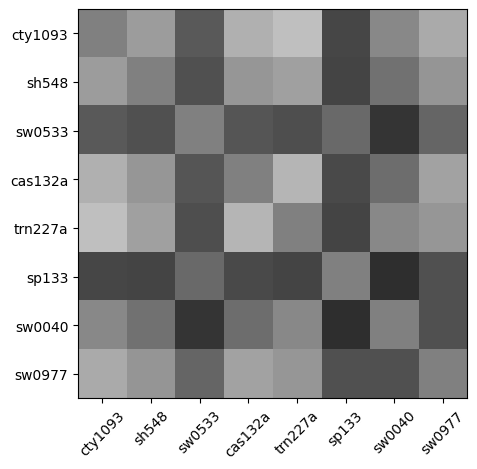

In [18]:
# Get the cosine similarity for the batch
sim = cosine_similarity(encodings)
np.fill_diagonal(sim, 0.5)  # 0.5 is probably not min, probably not max
print(f"Minimum similarity: {sim.min():.2f}")
print(f"Maximum similarity: {sim.max():.2f}")

plt.figure()
plt.imshow(sim, vmin=0, vmax=1, cmap="gray")
plt.xticks(range(len(batch["tag"])), batch["tag"], rotation=45)
plt.yticks(range(len(batch["tag"])), batch["tag"])
plt.tight_layout()
plt.show()

Similarity between cty1093 and trn227a is 0.75


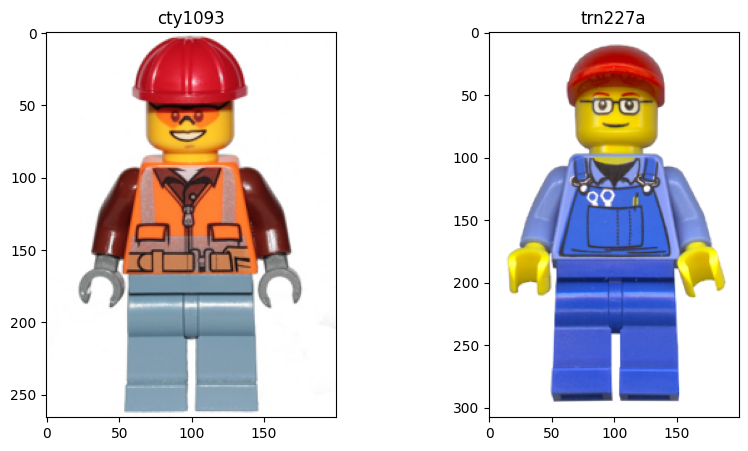

Similarity between sp133 and sw0040 is 0.18


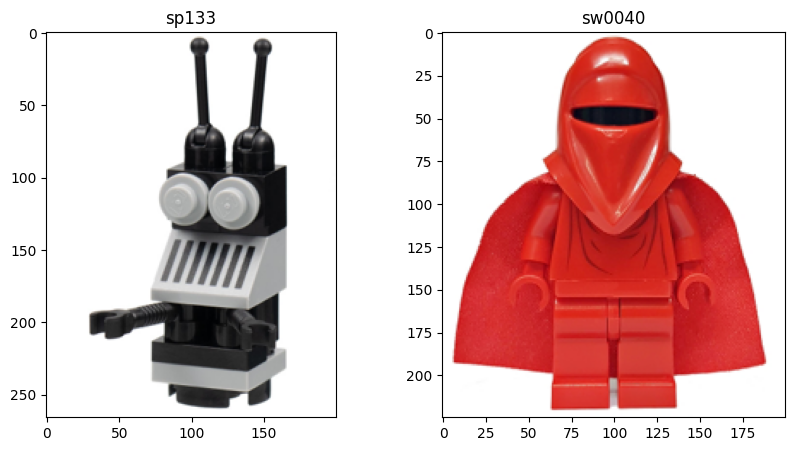

In [19]:
# Show the most and least similar images
idx = sim.argmax()
first, second = idx // len(batch["image"]), idx % len(batch["image"])
tag1 = batch["tag"][first]
tag2 = batch["tag"][second]
print(f"Similarity between {tag1} and {tag2} is {sim[first, second]:.2f}")

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag1}.png").permute(1, 2, 0))
axs[0].set_title(f"{tag1}")
axs[1].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag2}.png").permute(1, 2, 0))
axs[1].set_title(f"{tag2}")
plt.show()

idx = sim.argmin()
first, second = idx // len(batch["image"]), idx % len(batch["image"])
tag1 = batch["tag"][first]
tag2 = batch["tag"][second]
print(f"Similarity between {tag1} and {tag2} is {sim[first, second]:.2f}")

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag1}.png").permute(1, 2, 0))
axs[0].set_title(f"{tag1}")
axs[1].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag2}.png").permute(1, 2, 0))
axs[1].set_title(f"{tag2}")
plt.show()

In [20]:
# Manually select two similar images
tag1 = "cas321"
tag2 = "cas323"

# Load in the images
im1 = load_img(Path.cwd() / f"data/data/minifigures/{tag1}.png")
im2 = load_img(Path.cwd() / f"data/data/minifigures/{tag2}.png")

# Assemble the batch manually
im1 = dataset_train.transform_resize(im1[None,])[0]
im1 = dataset_train.transform_normalize(im1)
im2 = dataset_train.transform_resize(im2[None,])[0]
im2 = dataset_train.transform_normalize(im2)
images = torch.stack([im1, im2])
print(f"Shape: {images.shape}")
print(images.min(), images.max(), images.mean(), images.std())

Shape: torch.Size([2, 3, 256, 256])
tensor(-2.1179) tensor(2.6400) tensor(1.4783) tensor(1.5735)


Similarity between cas321 and cas323 is 0.91


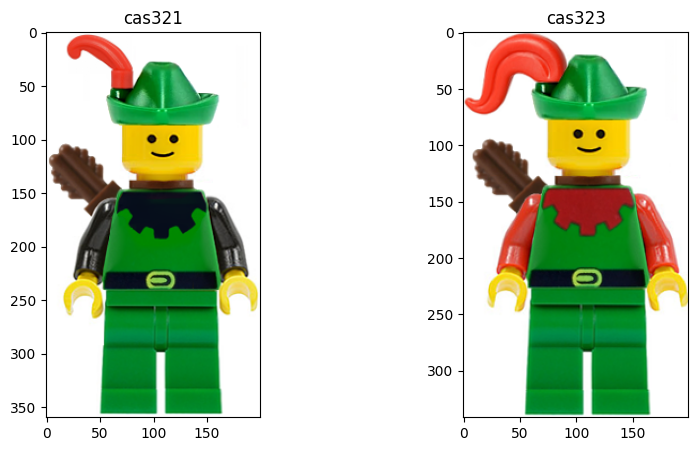

In [21]:
# Make a prediction, and get the cosine similarity
encodings = model(images).detach().numpy()
sim = cosine_similarity(encodings)
print(f"Similarity between {tag1} and {tag2} is {sim[0, 1]:.2f}")

_, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag1}.png").permute(1, 2, 0))
axs[0].set_title(f"{tag1}")
axs[1].imshow(load_img(Path.cwd() / f"data/data/minifigures/{tag2}.png").permute(1, 2, 0))
axs[1].set_title(f"{tag2}")
plt.show()

## Decoder head

Now we have good encodings of our images, we want to create decodings in order to classify our images. In order to do so, we're going to attach a _decoding head_ to our encoder. This is a simple feedforward layer, that will combine the different extracted features in order to make predictions.

**Questions:**
* **What are decoders?**
* **Can you only have one decoder?**
* **What are OneVsAll classifiers?**

In [22]:
# Rename the 'model' (encoder) to 'encoder'
encoder = model

In [23]:
decoder = nn.Sequential(
    nn.Linear(n_features, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, len(dataset_train.classes)),
)

# Analyze number of parameters
sum(
    p.numel() for p in decoder.parameters() if p.requires_grad
)  # Requires_grad for trainable parameters

172874

In [24]:
class EncoderDecoder(nn.Module):
    """Create a single EncoderDecoder model."""

    def __init__(self):
        """Initialise the model."""
        super().__init__()

        # Create the encoder
        self.encoder = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        n_features = self.encoder.classifier[1].in_features
        self.encoder.classifier[-1] = torch.nn.Identity()

        # Create the decoder
        self.decoder = nn.Sequential(
            nn.Linear(n_features, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(dataset_train.classes)),
        )

        # Freeze the encoder
        for param in self.encoder.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = EncoderDecoder()
model

EncoderDecoder(
  (encoder): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scal

In [25]:
# Analyze number of parameters
n_param_train = sum(p.numel() for p in model.parameters() if p.requires_grad)
n_param_frozen = sum(p.numel() for p in model.parameters() if not p.requires_grad)
print(f"Trainable parameters: {n_param_train}")
print(f"Frozen parameters: {n_param_frozen}")

Trainable parameters: 172874
Frozen parameters: 4007548


## Others

Next to the data and the model(s), PyTorch has support for other functionality that helps with training, evaluation, generating insights, ... .

**Questions:**
* **What are good metrics to use for evaluation?**
* **What is precision?**
* **What is recall?**
* **What is the F1-score?**

In [26]:
# Binary cross-entropy loss (since multi-class multi-label)
loss_fn = nn.BCEWithLogitsLoss()

In [27]:
# Custom metric (f1, class balanced)
def metric_class_balanced_f1(logits, target):
    """Calculate the class balanced f1 score."""
    # Note: logits >= 0.0, probs >= 0.5, targets are 'probs'
    f1s = [
        metric_f1_score(
            pred=(logits[:, i] >= 0.0).to(torch.float64),
            target=(target[:, i] >= 0.5).to(torch.float64),
        )
        for i in range(target.shape[1])
    ]
    return torch.mean(torch.tensor(f1s))


def metric_f1_score(pred, target):
    """The f1 score is the harmonic mean of precision and recall."""
    p = metric_precision(pred=pred, target=target)
    r = metric_recall(pred=pred, target=target)
    return 2 * (p * r) / max(p + r, 1e-8)


def metric_precision(pred, target):
    """Precision is the fraction of relevant instances among the retrieved instances."""
    if pred.sum() == 0:
        return 1.0  # Perfect precision, since no instances were retrieved
    if target.sum() == 0:
        return 0.0  # Zero precision, since no relevant instances exist
    tp = (pred * target).sum()
    fp = ((1 - target) * pred).sum()
    return float(tp / max(tp + fp, 1e-8))


def metric_recall(pred, target):
    """Recall is the fraction of the total amount of relevant instances that were actually retrieved."""
    if target.sum() == 0:
        return 1.0  # Perfact recall, since no relevant instances exist
    if pred.sum() == 0:
        return 0.0  # Zero recall, since no relevant instances were retrieved
    tp = (pred * target).sum()
    fn = (target * (1 - pred)).sum()
    return float(tp / max(tp + fn, 1e-8))


# Test out (don't mind the -0.1, this is to mimic a logits instead of a probability (prob-[0..1] where logits can be [-inf..inf]))
batch1 = next(iter(loader_train))
batch2 = next(iter(loader_train))
print(
    f"Perfect prediction: {metric_class_balanced_f1(logits=batch1['label'] - 0.1, target=batch1['label']):.2f}"
)
print(
    f"Random prediction: {metric_class_balanced_f1(logits=batch1['label'] - 0.1, target=batch2['label']):.2f}"
)

Perfect prediction: 1.00
Random prediction: 0.18


In [28]:
# Optimizers
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

## Simple training, validation, and testing

In order to train, validate, and test our model easily, we'll create some training, validation, and testing functions.

**Question: Which datasets should we use for training, why?**

In [29]:
# Define the train and test functions
def train(
    dataloader: DataLoader, model: EncoderDecoder, optimizer: torch.optim.Adam, epoch: int
) -> list[float]:
    """Train the model for one epoch."""
    model.train()
    losses, f1_scores = [], []
    with tqdm(total=len(dataloader), desc=f"Training epoch={epoch}") as pbar:
        for batch in dataloader:
            # Compute prediction error and f1 score
            pred = model(batch["image"])
            loss = loss_fn(pred, batch["label"])
            f1 = metric_class_balanced_f1(pred, batch["label"])

            # Save the loss
            losses.append(loss.item())
            f1_scores.append(f1.item())

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update progress bar
            pbar.set_postfix(
                {"loss": sum(losses) / len(losses), "f1": sum(f1_scores) / len(f1_scores)}
            )
            pbar.update()
    return losses, f1_scores


def validate(dataloader: DataLoader, model: EncoderDecoder, epoch: int) -> dict[str, float]:
    """Validate the model on the validation set, return f1 score and loss."""
    model.eval()
    test_loss, test_f1 = [], []
    with torch.no_grad(), tqdm(total=len(dataloader), desc=f"Validating epoch={epoch}") as pbar:
        for batch in dataloader:
            pred = model(batch["image"])
            test_loss += [loss_fn(pred, batch["label"]).item()] * batch["label"].shape[0]
            test_f1 += [metric_class_balanced_f1(pred, batch["label"]).item()] * batch[
                "label"
            ].shape[0]
            pbar.set_postfix(
                {"loss": sum(test_loss) / len(test_loss), "f1": sum(test_f1) / len(test_f1)}
            )
            pbar.update()
    return {"loss": sum(test_loss) / len(test_loss), "f1": sum(test_f1) / len(test_f1)}

In [ ]:
# Start training the model
n_epochs = 10
losses_train, losses_val, f1_train, f1_val = [None], [None], [None], [None]

# Perform an initial validation
metrics = validate(dataloader=loader_val, model=model, epoch=0)
losses_val[0] = metrics["loss"]
f1_val[0] = metrics["f1"]

# Train and validate the model over several epochs
for t in range(n_epochs):
    print(f"Epoch {t + 1}")
    losses_epoch, f1_epoch = train(
        dataloader=loader_train, model=model, optimizer=optimizer, epoch=t + 1
    )
    metrics = validate(dataloader=loader_val, model=model, epoch=t + 1)

    # Save the losses and accuracies
    losses_train += losses_epoch
    f1_train += f1_epoch
    losses_val += [None] * len(losses_epoch)
    f1_val += [None] * len(f1_epoch)
    losses_val[-1] = metrics["loss"]
    f1_val[-1] = metrics["f1"]

Validating epoch=0:   0%|          | 0/3 [00:00<?, ?it/s]

Validating epoch=0: 100%|██████████| 3/3 [00:01<00:00,  2.63it/s, loss=0.689, f1=0.19]  


Epoch 1


Validating epoch=1: 100%|██████████| 3/3 [00:00<00:00,  3.13it/s, loss=0.619, f1=0.229]


Epoch 2


Validating epoch=2: 100%|██████████| 3/3 [00:00<00:00,  3.52it/s, loss=0.605, f1=0.261]


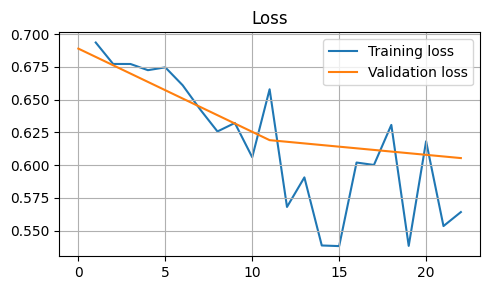

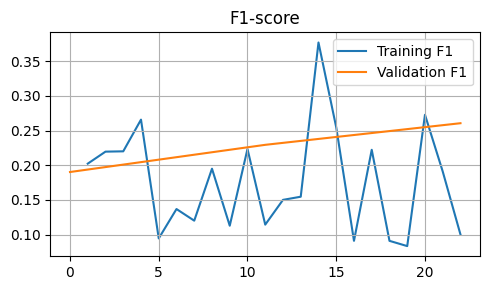

In [31]:
def _plot(x: list[float | None], label: str, zorder: int):
    i, x = zip(*[(i, x) for i, x in enumerate(x) if x is not None])
    plt.plot(i, x, label=label, zorder=zorder)


# Plot the losses
plt.figure(figsize=(5, 3))
plt.title("Loss")
_plot(losses_train, "Training loss", 1)
_plot(losses_val, "Validation loss", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Plot the accuracies
plt.figure(figsize=(5, 3))
plt.title("F1-score")
_plot(f1_train, "Training F1", 1)
_plot(f1_val, "Validation F1", 2)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## Evaluation

Evaluate the model.

In [32]:
# Put the model in evaluation mode
_ = model.eval()

In [33]:
# Create the predictions
predictions, targets = [], []
with torch.no_grad():
    for batch in loader_test:
        predictions.append(model(batch["image"]))
        targets.append(batch["label"])

predictions = torch.concat(predictions)
targets = torch.concat(targets)
assert predictions.shape == targets.shape

In [34]:
# Calculate the metrics
f1 = metric_class_balanced_f1(logits=predictions, target=targets).item()
loss = loss_fn(input=predictions, target=targets).item()
f1, loss

(0.08666666597127914, 0.5608127117156982)

In [35]:
# Evaluate for each class individually
f1_cls = {}
for i, cls in enumerate(classes):
    pred_ = (predictions[:, i] >= 0.0).to(torch.float64)
    target_ = (targets[:, i] >= 0.5).to(torch.float64)
    f1 = metric_f1_score(pred=pred_, target=target_)
    f1_cls[cls] = f1
f1_cls

{'alien': 0.0,
 'angry': 0.0,
 'cape': 0.0,
 'facial hair': 0.0,
 'glasses': 0.0,
 'happy': 0.0,
 'hat': 0.0,
 'helmet': 0.0,
 'human': 0.8666666666666666,
 'robot': 0.0}

In [36]:
# Wrap all of this in a function
def evaluate(model: EncoderDecoder, loader: DataLoader) -> dict[str, float]:
    """Evaluate the provided model."""
    model.eval()

    # Create the predictions
    predictions, targets = [], []
    with torch.no_grad():
        for batch in loader:
            predictions.append(model(batch["image"]))
            targets.append(batch["label"])
    predictions = torch.concat(predictions)
    targets = torch.concat(targets)

    # Calculate the metrics
    loss = loss_fn(input=predictions, target=targets).item()

    # Calculate F1 on class-level
    f1_cls, precision_cls, recall_cls = {}, {}, {}
    for i, cls in enumerate(classes):
        pred_ = (predictions[:, i] >= 0.0).to(torch.float64)
        target_ = (targets[:, i] >= 0.5).to(torch.float64)
        precision_cls[cls] = metric_precision(pred=pred_, target=target_)
        recall_cls[cls] = metric_recall(pred=pred_, target=target_)
        f1_cls[cls] = metric_f1_score(pred=pred_, target=target_)

    # Merge all results
    return {
        "f1": sum(f1_cls.values()) / len(f1_cls),
        "loss": loss,
        "precision_cls": precision_cls,
        "recall_cls": recall_cls,
        "f1_cls": f1_cls,
    }


evaluate(model=model, loader=loader_test)

{'f1': 0.08666666666666666,
 'loss': 0.5608127117156982,
 'precision_cls': {'alien': 1.0,
  'angry': 1.0,
  'cape': 1.0,
  'facial hair': 1.0,
  'glasses': 1.0,
  'happy': 1.0,
  'hat': 1.0,
  'helmet': 1.0,
  'human': 0.8125,
  'robot': 1.0},
 'recall_cls': {'alien': 0.0,
  'angry': 0.0,
  'cape': 0.0,
  'facial hair': 0.0,
  'glasses': 0.0,
  'happy': 0.0,
  'hat': 0.0,
  'helmet': 0.0,
  'human': 0.9285714285714286,
  'robot': 0.0},
 'f1_cls': {'alien': 0.0,
  'angry': 0.0,
  'cape': 0.0,
  'facial hair': 0.0,
  'glasses': 0.0,
  'happy': 0.0,
  'hat': 0.0,
  'helmet': 0.0,
  'human': 0.8666666666666666,
  'robot': 0.0}}

In [37]:
# Evaluate a newly created model as reference
evaluate(model=EncoderDecoder(), loader=loader_test)

{'f1': 0.2598119122257053,
 'loss': 0.7004892230033875,
 'precision_cls': {'alien': 0.0,
  'angry': 0.20833333333333334,
  'cape': 0.20833333333333334,
  'facial hair': 0.26666666666666666,
  'glasses': 0.25,
  'happy': 0.2857142857142857,
  'hat': 1.0,
  'helmet': 0.375,
  'human': 1.0,
  'robot': 0.20833333333333334},
 'recall_cls': {'alien': 0.0,
  'angry': 1.0,
  'cape': 1.0,
  'facial hair': 0.8,
  'glasses': 1.0,
  'happy': 0.5,
  'hat': 0.0,
  'helmet': 0.42857142857142855,
  'human': 0.0,
  'robot': 1.0},
 'f1_cls': {'alien': 0.0,
  'angry': 0.3448275862068966,
  'cape': 0.3448275862068966,
  'facial hair': 0.4,
  'glasses': 0.4,
  'happy': 0.36363636363636365,
  'hat': 0.0,
  'helmet': 0.39999999999999997,
  'human': 0.0,
  'robot': 0.3448275862068966}}

## Bonus - PR-curve

Since we have the functions to calculate precision and recall, we can create a PR-curve of our model. This will show how well our model performs over varying certainty thresholds. Note that this computation assumes probabilities, hence we need to transform our logits predictions first (using the Sigmoid function).

**Questions**
* **What does a certainty threshold depict?**
* **Does recall increase or decrease with rising certainty threshold? Is this consistent?**
* **Does precision increase or decrease with rising certainty threshold? Is this consistent?**

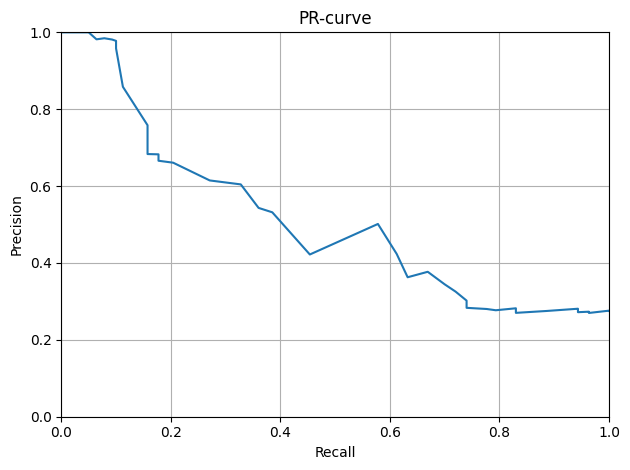

In [38]:
def show_pr(predictions, targets) -> None:
    """Create a PR-curve plot."""
    # Convert the predictions to probabilities
    probabilities = torch.sigmoid(predictions)

    # Calculate the precision and recall over a sliding window of thresholds
    precision, recall = [], []
    for thr in range(101):
        prob_thr = thr / 100.0

        precision_, recall_ = [], []
        for i in range(probabilities.shape[1]):
            pred_ = (probabilities[:, i] >= prob_thr).to(torch.float64)
            target_ = (targets[:, i] >= 0.5).to(torch.float64)
            precision_.append(metric_precision(pred=pred_, target=target_))
            recall_.append(metric_recall(pred=pred_, target=target_))
        precision.append(sum(precision_) / len(precision_))
        recall.append(sum(recall_) / len(recall_))

    # Create the plot
    plt.figure()
    plt.title("PR-curve")
    plt.plot(recall, precision, zorder=2)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid()
    plt.tight_layout()
    plt.show()


# Create a PR-curve for the model
show_pr(predictions=predictions, targets=targets)

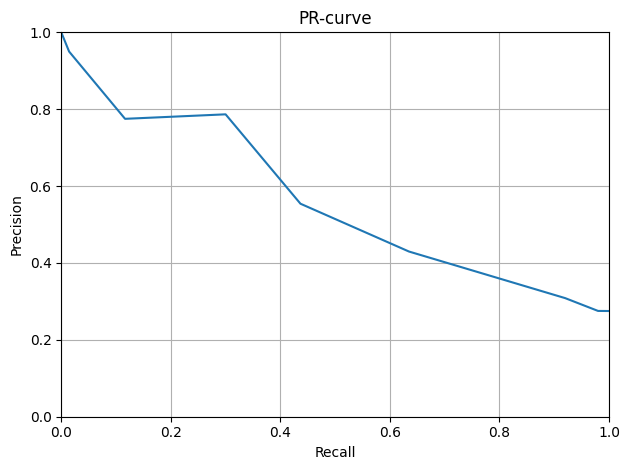

In [39]:
# Randomly init PR curve
random_model = EncoderDecoder()

# Create the predictions
random_predictions, random_targets = [], []
with torch.no_grad():
    for batch in loader_test:
        random_predictions.append(random_model(batch["image"]))
        random_targets.append(batch["label"])

random_predictions = torch.concat(random_predictions)
random_targets = torch.concat(random_targets)
assert random_predictions.shape == random_targets.shape

show_pr(predictions=random_predictions, targets=random_targets)